In [2]:
# hack to make notebook appear full-width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
import math
import csv
import pickle
from collections import namedtuple, defaultdict
import time
from glob import glob
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.utils.graph_shortest_path import graph_shortest_path
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle, ConnectionPatch

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Create Network Metadata

In [16]:
# Structure for node metadata
NodeMeta = namedtuple("NodeMeta", ["id", "name", "ip", "kind"])
# kind should be one of:
# - Server
# - External
# - Workstation
# - Vulnerable Workstation
# - Unknown

# Global list of all nodes
nodes = []

# Function to add a new node to the list
def addnode(ip, name, kind):
    id = len(nodes)
    nodes.append(NodeMeta(id, name, ip, kind))

# firewall, LANs, and servers
addnode("10.200.150.1", "Firewall", kind="Server")
addnode("192.168.1.1", "Vlan10", kind="Server")
addnode("192.168.2.1", "Vlan20", kind="Server")
addnode("172.20.1.1", "DMZ", kind="Server")
addnode("172.20.1.5", "ExtWeb", kind="Server")
addnode("192.168.1.2", "DHCP", kind="Server")
addnode("192.168.1.3", "HR DB", kind="Server")
addnode("192.168.1.4", "Ship DB", kind="Server")
addnode("192.168.1.5", "IntWeb", kind="Server")
addnode("192.168.1.6", "Mail", kind="Server")
addnode("192.168.1.7", "FileServ", kind="Server")
addnode("192.168.1.14", "DNS", kind="Server")
addnode("192.168.1.16", "Snort", kind="Server")
addnode("192.168.1.50", "FWLog", kind="Server")

# unknown (server IP space)
for i in list(range(8,14)) + [15] + list(range(17, 50)) + list(range(51, 256)):
    addnode(f"192.168.1.{i}", f"us{i}", kind="Unknown")

# external machines (public internet)
for i in range(2, 256):
    addnode(f"10.200.150.{i}", f"x{i}", kind="External")

# internal workstations
for i in range(10, 251):
    if 171 <= i <= 175:
        kind = "Vulnerable Workstation"
    else:
        kind = "Workstation"
    addnode(f"192.168.2.{i}", f"w{i}", kind=kind)
    
# unknown (workstation IP space)
for i in list(range(2, 10)) + list(range(251, 256)):
    addnode(f"192.168.2.{i}", f"uw{i}", kind="Unknown")
    
# lookup table into nodes by IP address
node_by_ip = {node.ip: node for node in nodes}

# Indentify firewall files

In [5]:
DATES = ["20110413", "20110414", "20110415"]
FWFILES = [fname
           for date in DATES
           for fname in glob(f"/Users/dbeach/Desktop/MiniChallenge2 Core Data/{date}/firewall/csv/{date}_VAST11MC2_firewall_log*.csv")
]

FWFILES

['/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_1.csv',
 '/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_2.csv',
 '/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_3.csv',
 '/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_4.csv',
 '/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_5.csv',
 '/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110414/firewall/csv/20110414_VAST11MC2_firewall_log.csv',
 '/Users/dbeach/Desktop/MiniChallenge2 Core Data/20110415/firewall/csv/20110415_VAST11MC2_firewall_log.csv']

In [6]:
# Structure for connection events
FWEvent = namedtuple("FWEvent", ["time", "source_ip", "dest_ip", "source_port", "dest_port", "conn_built", "conn_teardown"])

N_FIELDS = 15

(f_time, f_priority, f_operation, f_code, f_protocol, f_source_ip, f_dest_ip, f_source_host, f_dest_host,
 f_source_port, f_dest_port, f_dest_service, f_direction, f_num_conn_built, f_num_conn_teardown) = range(N_FIELDS)

def tryparseint(x, dft=0):
    try:
        return int(x)
    except ValueError:
        return dft

DATE_FORMAT = "%d/%b/%Y %H:%M:%S"
    
def parse_time(timestamp):
    return time.mktime(time.strptime(timestamp, DATE_FORMAT))
    
def parse_events(fname):
    reader = csv.reader(open(fname))
    header = next(reader) # throw away fields
    assert len(header) == N_FIELDS
    for rec in reader:
        if len(rec) != N_FIELDS:
            print(f"Skipping INVALID LINE: {rec}")
            continue
        t = parse_time(rec[f_time])
        source_ip = rec[f_source_ip]
        dest_ip = rec[f_dest_ip]
        if not source_ip or source_ip == "(empty)": continue
        if not dest_ip or dest_ip == "(empty)": continue
        source_port = tryparseint(rec[f_source_port])
        dest_port = tryparseint(rec[f_dest_port])
        conn_built = tryparseint(rec[f_num_conn_built])
        conn_teardown = tryparseint(rec[f_num_conn_teardown])
        yield FWEvent(t, source_ip, dest_ip, source_port, dest_port, conn_built, conn_teardown)
        
def parse_all_events():
    for fname in FWFILES:
        print(f"parsing file: {fname}")
        for event in parse_events(fname):
            yield event


# Build the Distance Graph

* The connection graph is a graph whose edge weights are labelled with positive values.
* In generaly, the higher the edge weight, the closer the relationship between nodes.
* We need to define distances that we can use in t-SNE.
* We start by defining probabilities between nodes.

Suppose:

- $w_{ij}$ is the edge weights of the connection graph
- $\Sigma w_{i}$ is the sum of all edge weights connecting to node $i$.

Then we can define:

$$p_{j|i} = {w_{ij} \over {\Sigma w_{i}}}$$
  
as the probability that node $i$ will connect to node $j$ assuming it is active.

However, because our graph is symmetric, we need to symmetrize these probabilities, so we define:

$$p_{ij} = {(p_{i|j} + p_{j|i}) \over 2}$$
  
Finally, we convert this probability into a distance (cost) by taking the negative log:

$$d_{ij} = - \log p_{ij}$$

The following block of code builds this graph.

In [64]:
class ConnectionGraph:
    
    def __init__(self):
        self._conn = defaultdict(int)
        self._weights = defaultdict(int)
        
    def tally(self, src_ip, dest_ip, num=1):
        src = node_by_ip[src_ip].id
        dest = node_by_ip[dest_ip].id
        self._conn[src, dest] += num
        self._conn[dest, src] += num
        self._weights[src] += num
        self._weights[dest] += num
    
    def get_prob_graph(self):
        conn = self._conn
        weights = self._weights
        xrows = [k[0] for k in conn.keys()]
        xcols = [k[1] for k in conn.keys()]

        # symmetrized conditional probability:
        xvals = [0.5 * (val/weights[i] + val/weights[j]) for (i,j), val in conn.items()]

        N = len(nodes)
        prob_graph = csr_matrix((xvals, (xrows, xcols)), shape=(N, N))
        return prob_graph

    
def get_dist_graph(prob_graph):
    return -np.log(prob_graph)
        

def get_dist_func(dist_graph):
    return graph_shortest_path(dist_graph)
    
        

def build_connection_graphs(splits):
    S = len(splits) + 1
    graphs = [ConnectionGraph() for _ in range(S)]
    start_time = None
    curr_index = 0
    curr_graph = graphs[0]
    next_split = splits[0]
    for event in parse_all_events():
        t = event.time
        if start_time == None:
            start_time = t
        end_time = t
        while t >= next_split:
            curr_index += 1
            curr_graph = graphs[curr_index]
            next_split = splits[curr_index] if curr_index < len(splits) else 1e100
        num = event.conn_built
        if num == 0: continue
        curr_graph.tally(event.source_ip, event.dest_ip, num)
    return graphs

In [19]:
class TopologyGraph:
    
    def __init__(self):
        self._hops = {}
        
    def connect(self, src_ip, dest_ip, hops=1):
        src = node_by_ip[src_ip].id
        dest = node_by_ip[dest_ip].id
        self._hops[src, dest] = hops
        self._hops[dest, src] = hops
    
    def get_dist_graph(self):
        hops = self._hops
        xrows = [k[0] for k in hops.keys()]
        xcols = [k[1] for k in hops.keys()]
        xvals = list(hops.values())

        # create connection graph as a sparse matrix
        N = len(nodes)
        dist_graph = csr_matrix((xvals, (xrows, xcols)), shape=(N, N))
        return dist_graph
        

In [55]:
topo = TopologyGraph()

INTERFACES = ["10.200.150.1", "192.168.1.1", "192.168.2.1", "172.20.1.1"]

for if1 in INTERFACES:
    for if2 in INTERFACES:
        if if1 != if2:
            topo.connect(if1, if2)

topo.connect("172.20.1.1", "172.20.1.5")

for i in range(2, 256):
    topo.connect("192.168.1.1", f"192.168.1.{i}")
    topo.connect("192.168.2.1", f"192.168.2.{i}")
    topo.connect("10.200.150.1", f"10.200.150.{i}", hops=1)


topo.get_dist_graph()

<767x767 sparse matrix of type '<class 'numpy.int64'>'
	with 1538 stored elements in Compressed Sparse Row format>

In [65]:
start_time = parse_time("13/Apr/2011 00:00:00")
end_time = parse_time("17/Apr/2011 00:00:00")
splits = []
s = start_time
while s < end_time:
    s += 6 * 60 * 60 # 6 hours
    splits.append(s)
graphs = build_connection_graphs(splits)

parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_1.csv
parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_2.csv
parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_3.csv
parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_4.csv
parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110413/firewall/csv/20110413_VAST11MC2_firewall_log_5.csv
parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110414/firewall/csv/20110414_VAST11MC2_firewall_log.csv
Skipping INVALID LINE: []
parsing file: /Users/dbeach/Desktop/MiniChallenge2 Core Data/20110415/firewall/csv/20110415_VAST11MC2_firewall_log.csv
Skipping INVALID LINE: []


In [63]:
# pickle.dump({"graphs": graphs, "gweights": gweights}, open("conn-graphs-6h.pickle", "wb"))

In [65]:
# data = pickle.load(open("conn-graphs-6h.pickle", "rb"))
# graphs = data["graphs"]
# gweights = data["gweights"]

## Complete distance function

To complete the distance function, we use Dijkstra's shortet path algorithm to compute the distance between all connected nodes.

Since the edge weights are logs of conditional probabilities, summed paths through the graph can be interpreted as the product of these conditional probabilities.

Note: There may be a better algorithm to use for nodes which are connected by multiple paths, since this would actually make the nodes closer.  However, using the strongest path (with the lowest cost) is a fair approximation for now.

In [84]:
def get_y(dist_graph):
    
    if dist_graph.shape == (0,0):
        return (np.zeros(0), [])

    dist_func = graph_shortest_path(dist_graph)
    keep_idxs = np.nonzero(np.sum(dist_func, 0) > 0)[0]
    
    dist_func = dist_func[keep_idxs,:][:,keep_idxs]
    
    tsne = TSNE(perplexity=10.0, metric="precomputed", n_iter=1000, learning_rate=50.0)
    y = tsne.fit_transform(dist_func)
    return y, keep_idxs


In [72]:
def make_map(ax, y, keep_idx): #, weights):

    gnodes = [nodes[idx] for idx in keep_idx]
    N = len(keep_idx)

    colormap = {
        "Server": "#d95f02",
        "External": "#e7298a",
        "Workstation": "#7570b3",
        "Vulnerable Workstation": "#e6ab02",
        "Unknown": "#66a61e"
    }

    colors = [colormap[gnodes[i].kind] for i in range(N)]

    # This gives sizes that are related to node activity.
    # Uses shifted logrithmic scaling to avoid making impossibly small dots.
    #gweights = [weights[i] for i in keep_idx]
    #medw = median(gweights)
    #log2 = math.log(2)
    def getsize(w):
        return 80
        #return 800 * math.log(1 + (w / medw)) / log2 # strange math, but better size variation

    #sizes = [getsize(w) for w in gweights]
    sizes = [80] * N

    #fig, ax = plt.subplots(figsize=(10,10))
    ax.axis('equal') # graph will appear distorted if axes are not equal
    #ax.axis('off')   # the numerical values of the axes don't matter, so suppress them
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    ax.scatter(y[:,0], y[:,1], color=colors, s=sizes, marker='o', alpha=0.5)

    for i in range(N):
        node = gnodes[i]
        
        if node.kind != "Server": continue
        size = 15 if node.kind == "Server" else 8
        ax.annotate(node.name, xy=y[i], horizontalalignment='center', verticalalignment='center', size=size)

#     # legend
#     legend_patches = []
#     # patches for machine types
#     for (stype, color) in colormap.items():
#         patch = ax.scatter([], [], color=color, marker="o", s=getsize(medw), alpha=0.5, label=stype)
#         legend_patches.append(patch)
#     # size scale
#     for factor in [2,3,4,5]:
#         w = 10**factor
#         size=getsize(w)
#         patch = ax.scatter([], [], color="#707070", marker="o", s=size, alpha=0.5, label="{:,.0f} connections".format(w))
#         legend_patches.append(patch)

    #ax.legend(handles=legend_patches, labelspacing=5, handlelength=5, handletextpad=2., borderpad=3, ncol=2, loc=3)


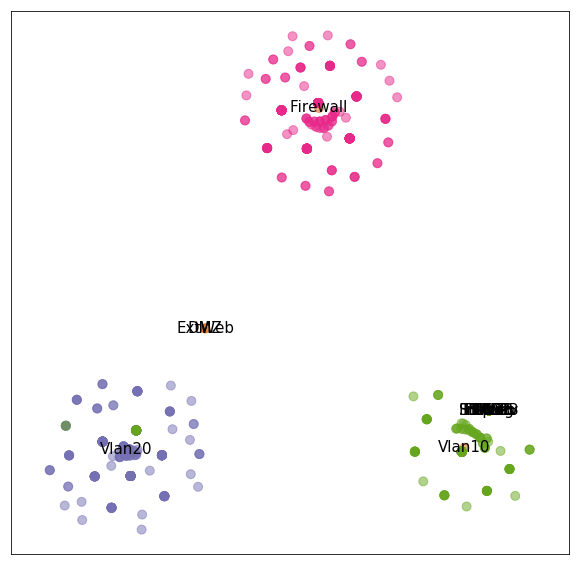

In [85]:
y, keep_idx = get_y(topo.get_dist_graph())
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
make_map(ax, y, keep_idx)

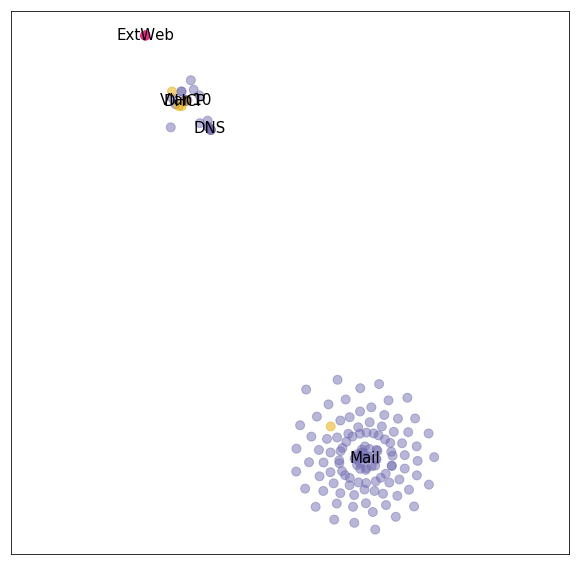

In [86]:
y, keep_idx = get_y(graphs[1].get_dist_graph())
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
make_map(ax, y, keep_idx)

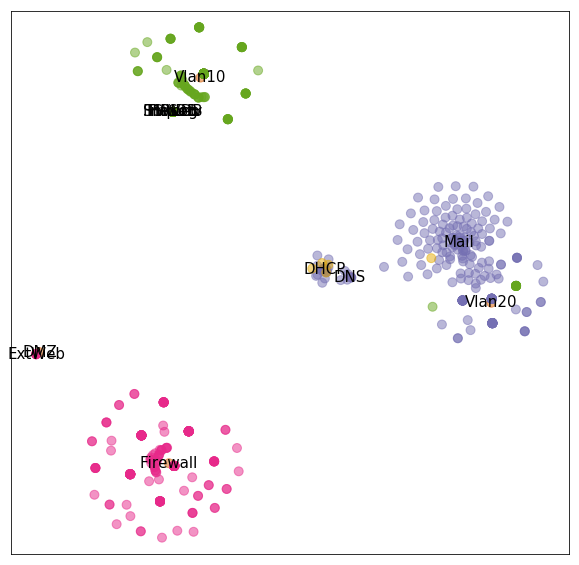

In [93]:
y, keep_idx = get_y(topo.get_dist_graph() + 0.33 * graphs[1].get_dist_graph())
plt.figure(figsize=(10,10))
ax = plt.subplot(1, 1, 1)
make_map(ax, y, keep_idx)

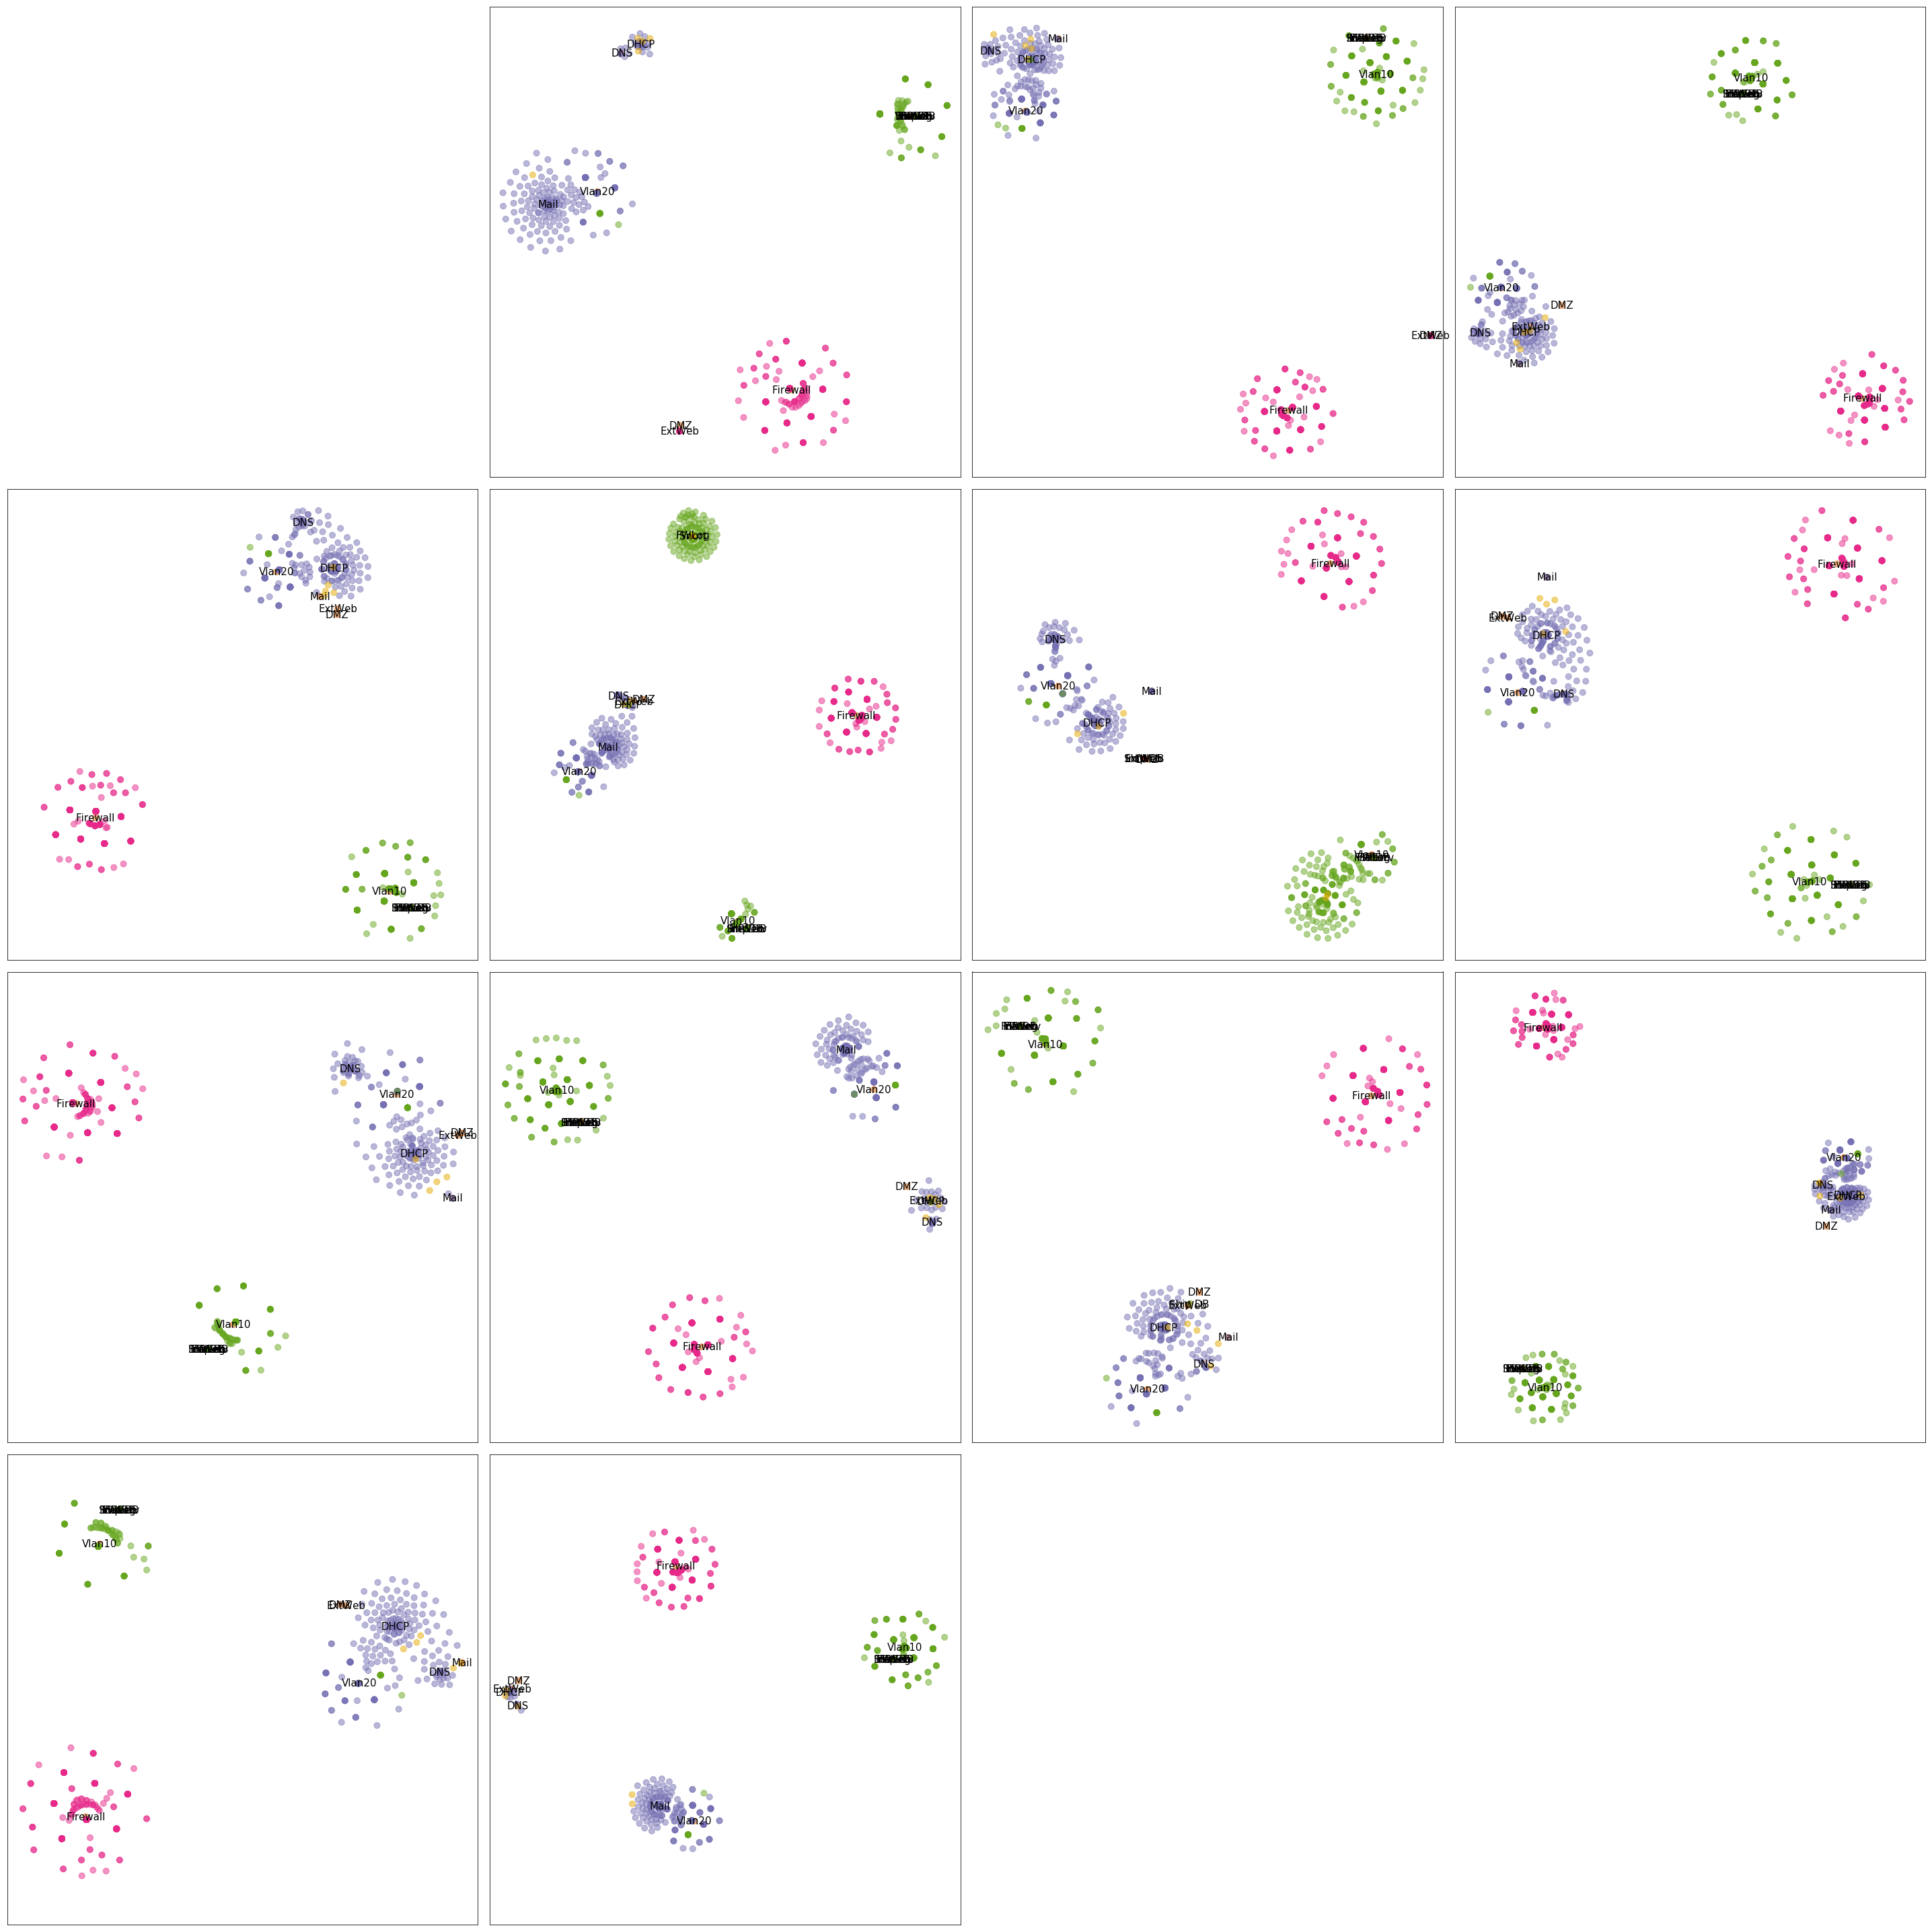

In [95]:
plt.figure(figsize=(40,40))
for i in range(len(graphs)):
    if len(graphs[i]._conn) > 0:
        y, keep_idx = get_y(topo.get_dist_graph() + 0.33 * graphs[i].get_dist_graph())        
        ax = plt.subplot(4, 4, i+1)
        make_map(ax, y, keep_idx)
plt.tight_layout()

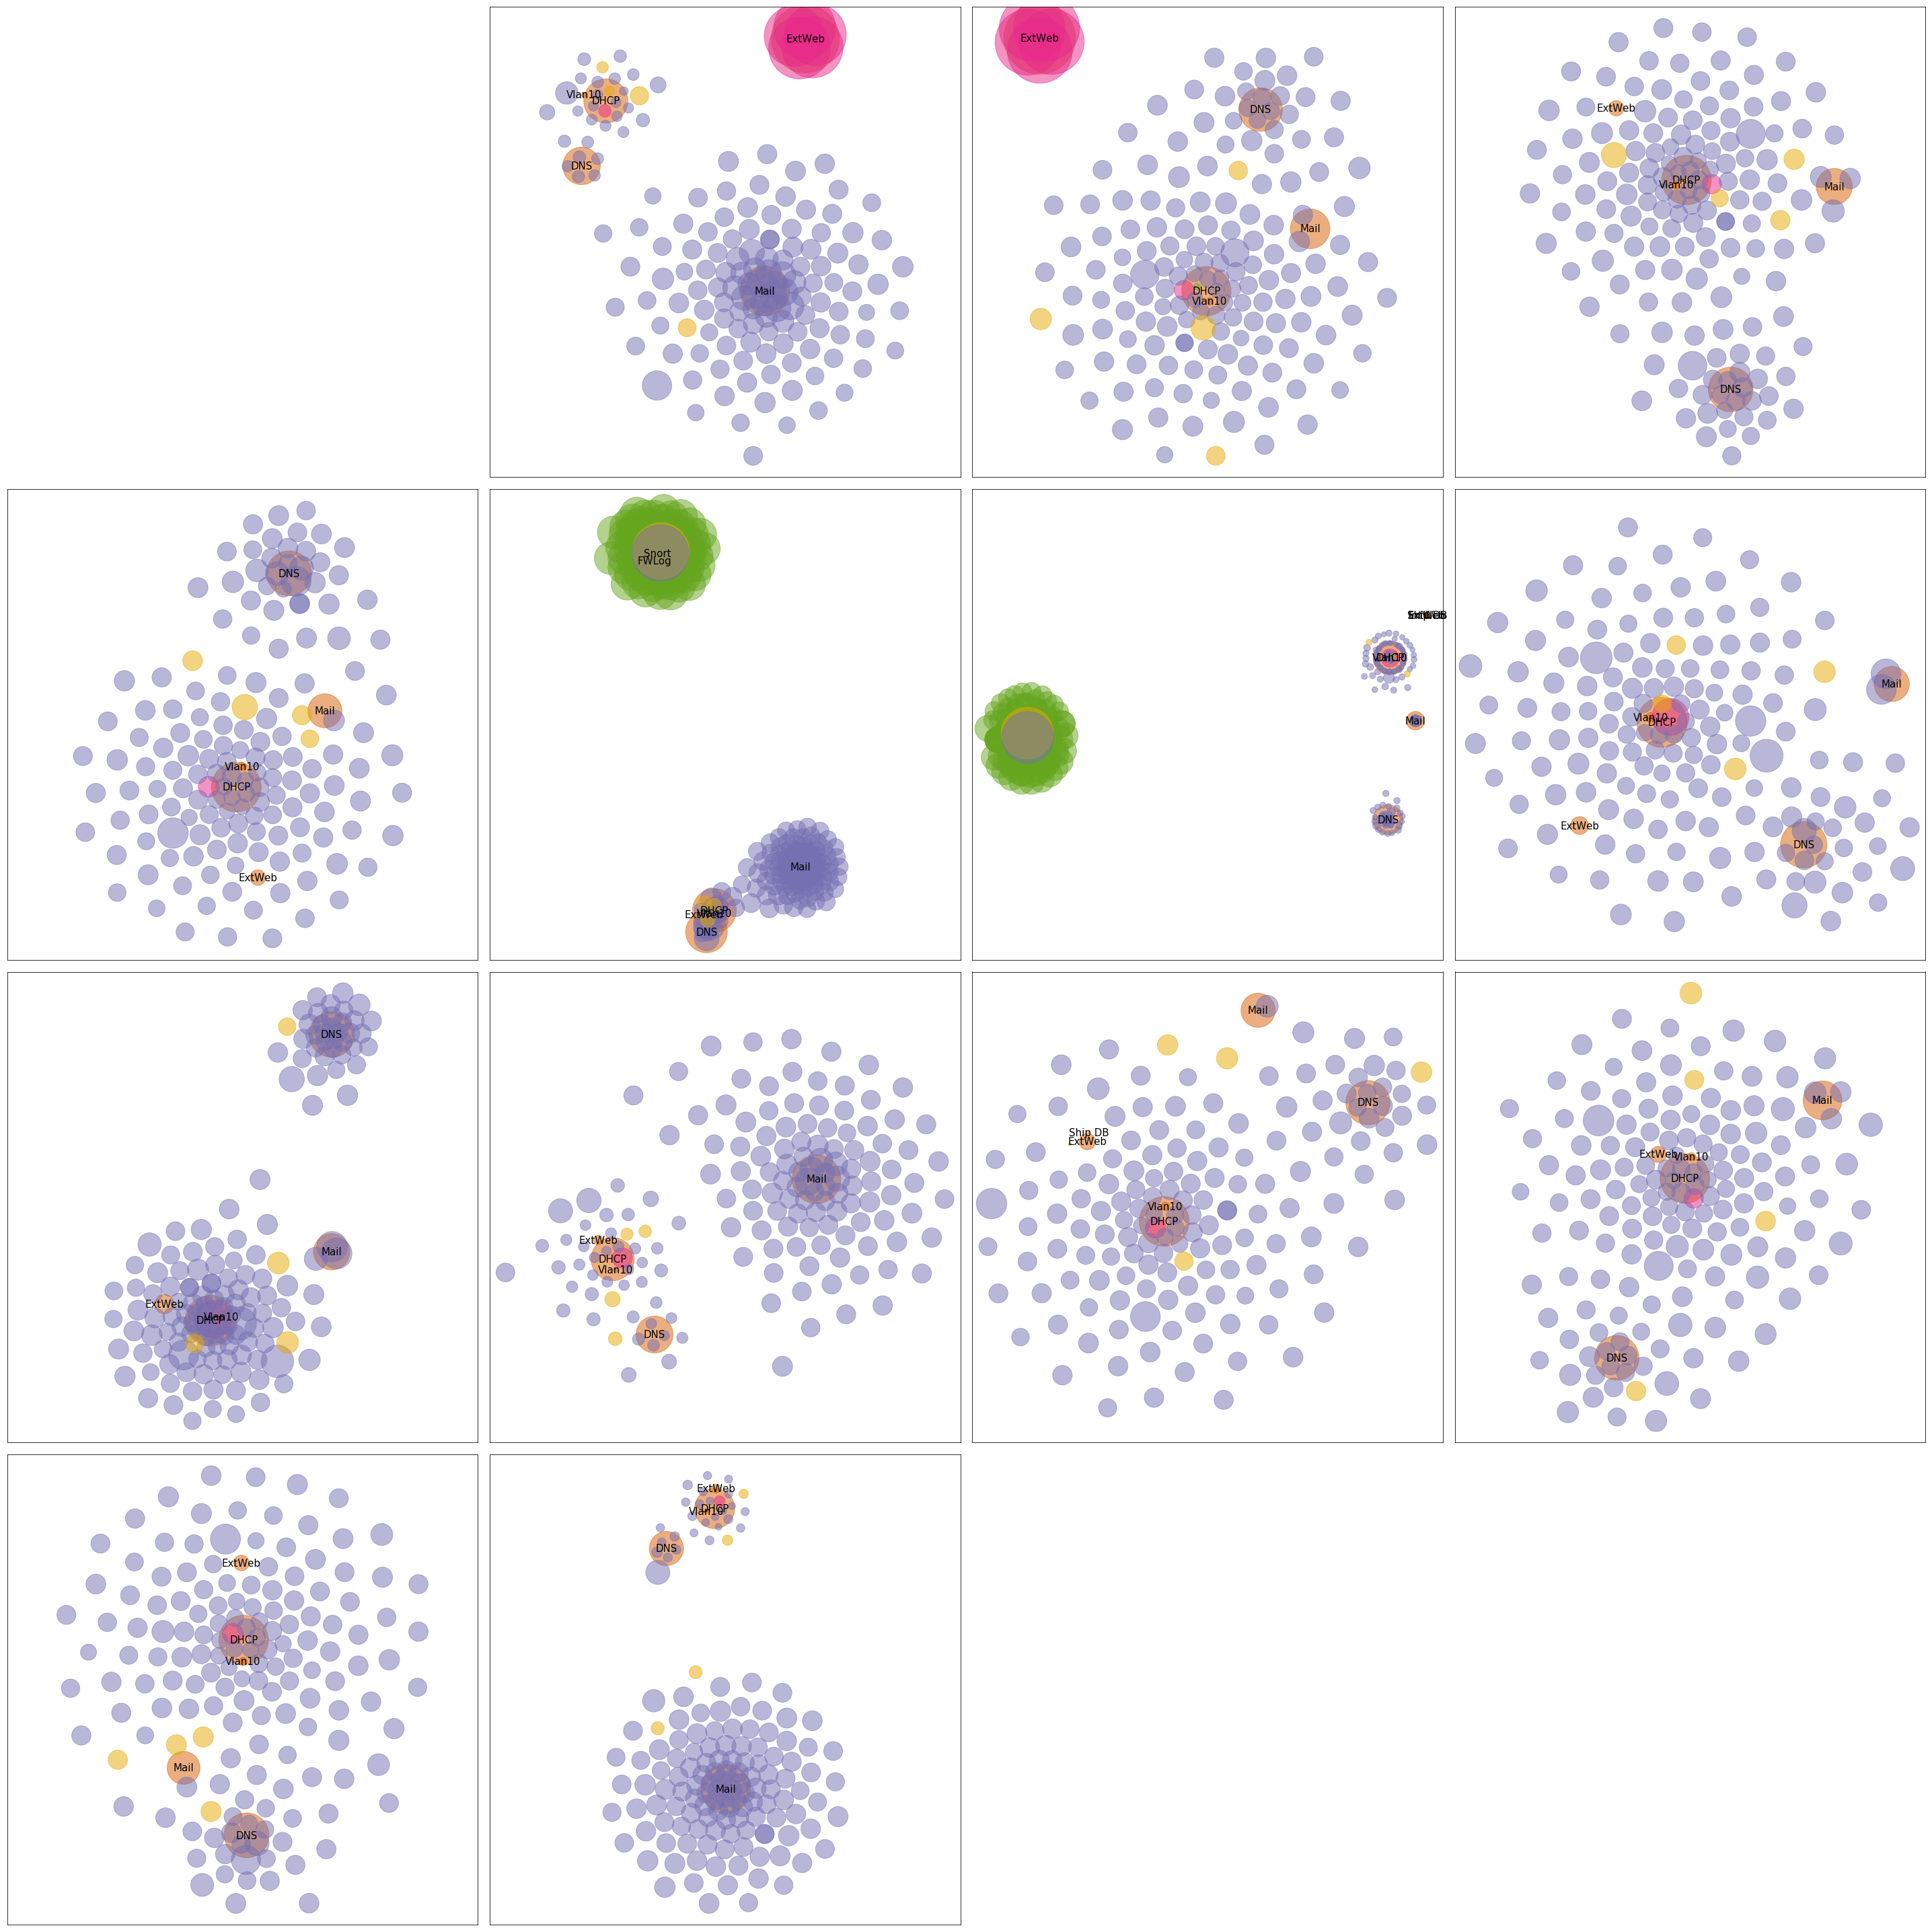

In [234]:
plt.figure(figsize=(40,40))
for i in range(len(graphs)):
    if len(yvals[i]) > 0:
        ax = plt.subplot(4, 4, i+1)
        make_map(ax, yvals[i], keep_idxs[i], gweights[i])
plt.tight_layout()
